## Part 2 (a)

In [56]:
import numpy as np
import matplotlib.pyplot as plt

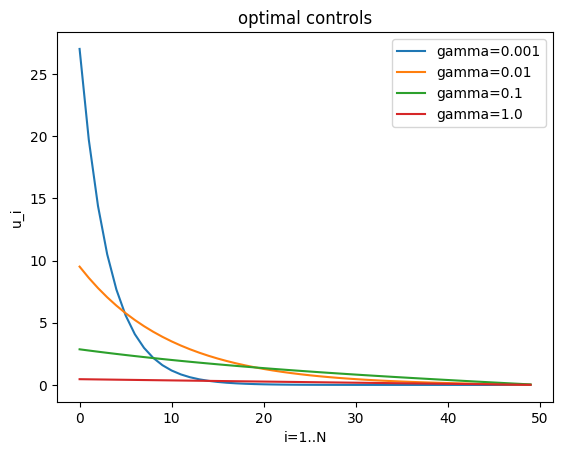

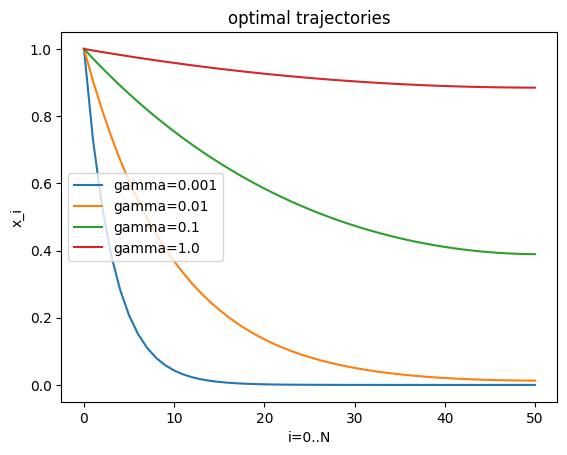

In [57]:
def S_matrix(a, b, N):
    S = np.zeros((N+1, N))
    for i in range(1, N+1):
        for k in range(1, i+1):
            S[i, k-1] = (a**(i-k)) * b
    return S

def vec_a(a, N):
    return np.array([a**i for i in range(N+1)])  # multiplies xbar outside

def solve_u_star(a, b, N, xbar, gamma):
    S = S_matrix(a, b, N)
    r = vec_a(a, N)
    lhs = S.T @ S + gamma * np.eye(N)
    rhs = - S.T @ r * xbar
    u = np.linalg.inv(lhs) @ rhs
    x = xbar * r + S @ u
    return u, x

N, a, b, xbar = 50, 1.0, -0.01, 1.0
gammas = [1e-3, 1e-2, 1e-1, 1.0]
U, X = [], []
for g in gammas:
    u, x = solve_u_star(a, b, N, xbar, g)
    U.append(u)
    X.append(x)

plt.figure()
[plt.plot(u, label=f'gamma={g}') for g,u in zip(gammas,U)]
plt.xlabel('i=1..N')
plt.ylabel('u_i')
plt.legend()
plt.title('optimal controls')
plt.show()

plt.figure()
[plt.plot(x, label=f'gamma={g}') for g,x in zip(gammas,X)]
plt.xlabel('i=0..N')
plt.ylabel('x_i')
plt.legend()
plt.title('optimal trajectories')
plt.show()

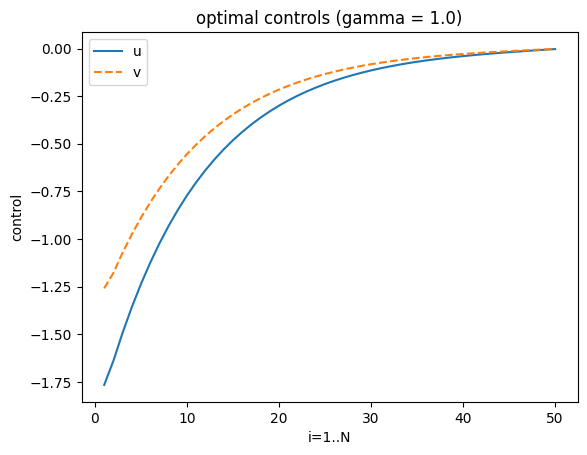

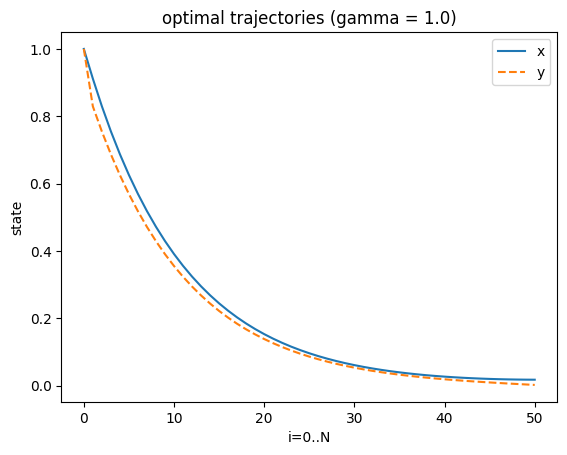

In [58]:
def solve_uv_star(a, b, N, xbar, c, d, ybar, gamma):
    Sx = S_matrix(a, b, N)
    Sy = S_matrix(c, d, N)
    rx = vec_a(a, N)
    ry = vec_a(c, N)

    I = np.eye(N)
    S_xy = np.block([[Sx, np.zeros_like(Sx)],
                     [np.zeros_like(Sx), Sy]])
    I_block = np.block([[I, -I],
                        [-I, I]])
    r_xy = np.concatenate([xbar * rx, ybar * ry])

    lhs = S_xy.T @ S_xy + gamma * I_block
    rhs = - S_xy.T @ r_xy

    z = np.linalg.inv(lhs) @ rhs
    u = z[:N]
    v = z[N:]

    x = xbar * rx + Sx @ u
    y = ybar * ry + Sy @ v
    return u, v, x, y


N, a, b, xbar = 50, 1.0, 0.05, 1.0
c, d, ybar = 0.2, -0.5, 1.0
gamma = 1.0

u, v, x, y = solve_uv_star(a, b, N, xbar, c, d, ybar, gamma)

# controls: plot u and v (single gamma)
plt.figure()
plt.plot(np.arange(1, N+1), u, label='u')
plt.plot(np.arange(1, N+1), v, '--', label='v')
plt.xlabel('i=1..N')
plt.ylabel('control')
plt.legend()
plt.title(f'optimal controls (gamma = {gamma})')
plt.show()

# trajectories: plot x and y (single gamma)
plt.figure()
plt.plot(np.arange(0, N+1), x, label='x')
plt.plot(np.arange(0, N+1), y, '--', label='y')
plt.xlabel('i=0..N')
plt.ylabel('state')
plt.legend()
plt.title(f'optimal trajectories (gamma = {gamma})')
plt.show()

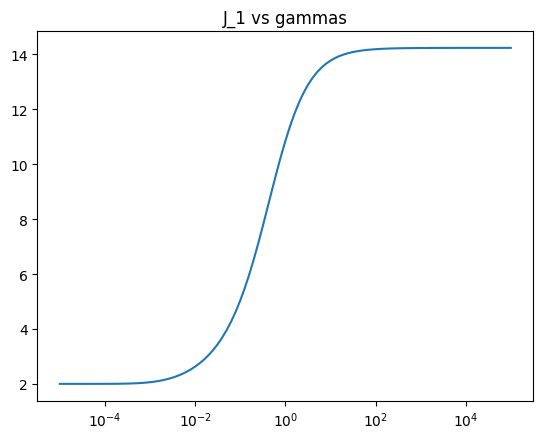

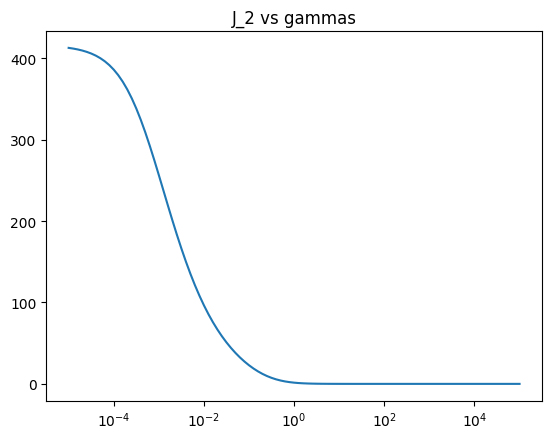

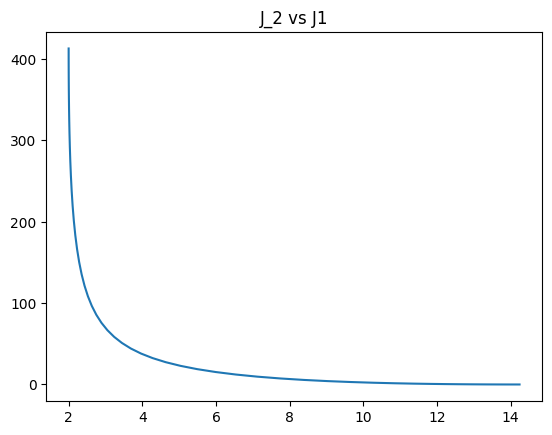

In [59]:
gammas = 10 ** (np.arange(-50, 51) / 10)

def j_1(gamma):
    N, a, b, xbar = 50, 1.0, 0.05, 1.0
    c, d, ybar = 0.2, -0.5, 1.0
    u, v, x, y = solve_uv_star(a, b, N, xbar, c, d, ybar, gamma)
    return np.linalg.norm(x)**2 + np.linalg.norm(y)**2

def j_2(gamma):
    N, a, b, xbar = 50, 1.0, 0.05, 1.0
    c, d, ybar = 0.2, -0.5, 1.0
    u, v, x, y = solve_uv_star(a, b, N, xbar, c, d, ybar, gamma)
    return np.linalg.norm(u - v)**2

j1 = []
j2 = []
for gamma in gammas:
    j1.append(j_1(gamma))
    j2.append(j_2(gamma))

plt.figure()
plt.xscale("log")
plt.plot(gammas, j1)
plt.title("J_1 vs gammas")
plt.show()

plt.figure()
plt.xscale("log")
plt.plot(gammas, j2)
plt.title("J_2 vs gammas")
plt.show()

plt.figure()
# plt.xscale("log")
plt.plot(j1, j2)
plt.title("J_2 vs J1")
plt.show()

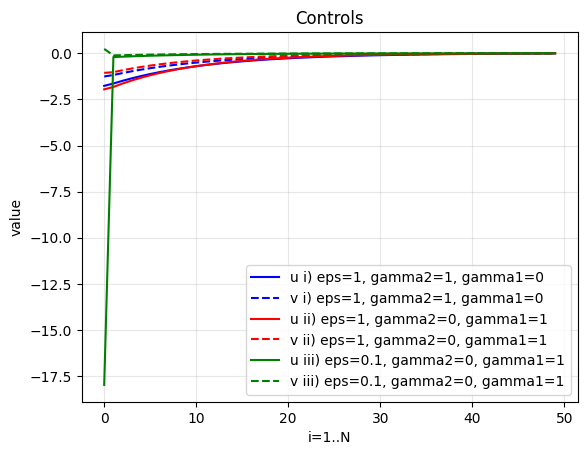

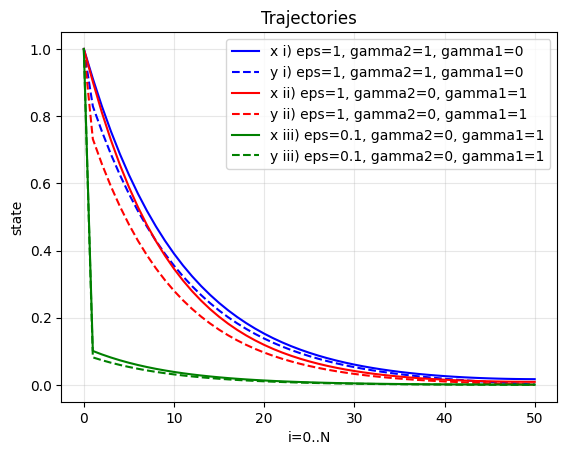

In [62]:
def L_eps(w, eps):
    w = np.asarray(w)
    quad = 0.5 * w**2
    lin  = eps * (np.abs(w) - 0.5*eps)
    return np.where(np.abs(w) <= eps, quad, lin)

def dL_eps(w, eps):
    w = np.asarray(w)
    return np.where(np.abs(w) <= eps, w, eps * np.sign(w))

def build_Sxy_rxy(a, b, xbar, c, d, ybar, N):
    Sx, rx = S_matrix(a, b, N), vec_a(a, N)
    Sy, ry = S_matrix(c, d, N), vec_a(c, N)
    Sxy = np.block([[Sx, np.zeros_like(Sx)], [np.zeros_like(Sy), Sy]])
    rxy = -np.concatenate([xbar * rx, ybar * ry])
    return Sxy, rxy, (Sx, rx, Sy, ry)

def D_op(N):
    I = np.eye(N)
    D = np.hstack([I, -I])
    D_norm_sq = 2.0
    return D, D_norm_sq

def J_grad(w, N, a, b, xbar, c, d, ybar, gamma2, gamma1, eps):
    Sxy, rxy, (Sx, rx, Sy, ry) = build_Sxy_rxy(a, b, xbar, c, d, ybar, N)
    D, D_norm_sq = D_op(N)
    return 2 * Sxy.T @ (Sxy @ w - rxy) + 2 * gamma2 * D.T @ D @ w + gamma1 * D.T @ dL_eps(D @ w, eps)

def gd(
    N, a, b, xbar, c, d, ybar,
    gamma2, gamma1, eps,
    alpha=None, iters=20000, tol=1e-9, return_hist=False
):
    np.random.seed(0)
    u = np.random.randn(N)
    v = np.random.randn(N)
    w = np.concatenate([u, v])

    Sxy, rxy, (Sx, rx, Sy, ry) = build_Sxy_rxy(a, b, xbar, c, d, ybar, N)
    D, D_norm_sq = D_op(N)

    if alpha is None:
        Sxy_norm_sq = np.linalg.norm(Sxy, 2)**2
        L = 2*Sxy_norm_sq + (2*gamma2 + gamma1) * D_norm_sq
        alpha = 1.0 / max(L, 1e-12)

    hist = []
    for k in range(iters):
        u, v = w[:N], w[N:]
        grad = J_grad(w, N=N, a=a, b=b, xbar=xbar, c=c, d=d, ybar=ybar, gamma2=gamma2, gamma1=gamma1, eps=eps)

        w_new = w - alpha * grad

        if np.linalg.norm(w_new - w) < tol * (1.0 + np.linalg.norm(w)):
            w = w_new
            break
        w = w_new
        u, v = w[:N], w[N:]
        if return_hist and (k % 20 == 0):
            x = xbar*rx + Sx@w[:N]; y = ybar*ry + Sy@w[N:]
            J = np.sum(x**2) + np.sum(y**2) \
                + gamma2*np.linalg.norm(u - v) + gamma1*np.sum(L_eps(D @ w, eps))
            hist.append(J)
    u, v = w[:N], w[N:]
    x = xbar*rx + Sx@u
    y = ybar*ry + Sy@v
    return u, v, x, y, (hist if return_hist else None), alpha



N, a, b, xbar = 50, 1.0, 0.05, 1.0
c, d, ybar = 0.2, -0.5, 1.0

cases = [
    dict(eps=1.0, gamma2=1.0, gamma1=0.0, name="i) eps=1, gamma2=1, gamma1=0", color='b'),
    dict(eps=1.0, gamma2=0.0, gamma1=1.0, name="ii) eps=1, gamma2=0, gamma1=1", color='r'),
    dict(eps=0.1, gamma2=0.0, gamma1=1.0, name="iii) eps=0.1, gamma2=0, gamma1=1", color='g')
]

results = []
costum_alpha = None
for cfg in cases:
    u, v, x, y, hist, alpha = gd(
        N, a, b, xbar, c, d, ybar, alpha=costum_alpha,
        gamma2=cfg["gamma2"], gamma1=cfg["gamma1"], eps=cfg["eps"], return_hist=True
    )
    results.append((cfg["name"], u, v, x, y, alpha, hist, cfg['color']))


# plot controls
plt.figure()
for name,u,v,x,y,alpha,hist,color in results:
    plt.plot(u, color=color, label=f"u {name}")
    plt.plot(v, '--', color=color, label=f"v {name}")
plt.xlabel('i=1..N')
plt.ylabel('value')
plt.title('Controls')
plt.legend()
plt.grid(True, alpha=0.3)

# plot trajectories
plt.figure()
for name,u,v,x,y,alpha,hist,color in results:
    plt.plot(x, color=color, label=f"x {name}")
    plt.plot(y, '--',color=color, label=f"y {name}")
plt.xlabel('i=0..N')
plt.ylabel('state')
plt.title('Trajectories')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


iterations of the case i) eps=1, gamma2=1, gamma1=0: 44
iterations of the case ii) eps=1, gamma2=0, gamma1=1: 37
iterations of the case iii) eps=0.1, gamma2=0, gamma1=1: 319


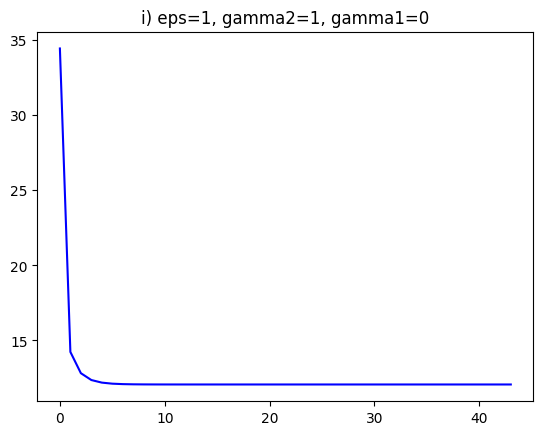

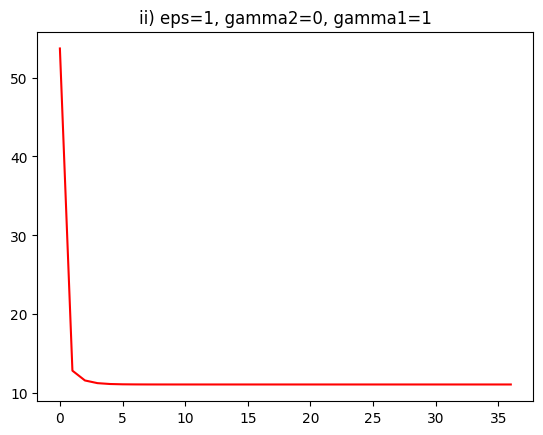

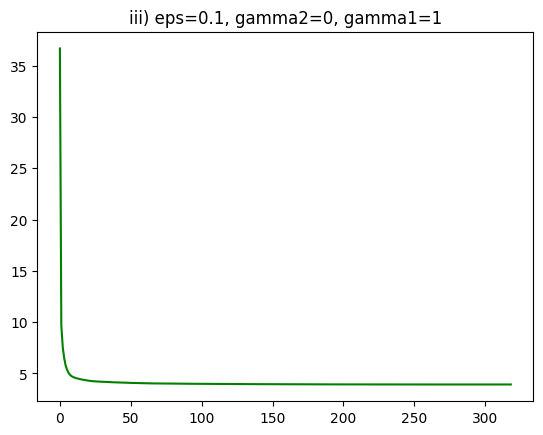

In [63]:
for name,u,v,x,y,alpha,hist,color in results:
    print(f"iterations of the case {name}: {len(hist)}")
    plt.figure()
    plt.plot(hist, color=color, label=f"u {name}")
    plt.title(name)